# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

# Midterm review 

~5 True/False, ~6 short answer

Covers all topics up through Wed 2/20 Lecture.

**Topics:** 
- Twitter API 
 - what comes in a tweet? 
 - how do rate limits work? 
 - can you understand API documentation? 
- graph basics: 
 - directed/undirected 
 - path 
 - cycle 
 - connected 
 - connected component 
 - degree (distribution) 
 - diameter 
 - average path length 
 - clustering coefficient 
- modeling networks 
 - random graphs 
 - regular graphs 
 - rewired graphs 
 - what makes a small world? 
- community detection 
 - girvan-newman (betweenness) 
 - graph cuts 
 - representing graphs with matrices 
 - graph laplacian 
- link prediction 
 - shortest path 
 - common neighbors 
 - jaccard 
 - preferential attachment 
 - sim rank 
 - evaluation 
- information cascades 
 - urn experiment 
 - bayes' theorem for decision making 
 - game-theoretic model 
 - maximizing payoff 
	- cluster density 
- sentiment analysis 
 - lexicon approach 
 - machine learning 
 
**Question types:** 
- What does this algorithm output? 
 - E.g., what is jaccard score for a specific link? 
 - E.g., what is the next step in girvan-newman? 
- What does this code do? 
 - E.g., I give you a new graph-generating algorithm, tell me what it produces 
- Write a new algorithm 
 - E.g., provide pseudo-code the linear-threshold cascade model 
- True/False 
 - E.g., small world graphs have higher clustering coefficients than random graphs.

<br><br><br>

## Content Analysis

Rather than just analyzing a network, we will now turn to analyzing what is said within the network.

### Sentiment Analysis

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?

<br><br>


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [41]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), 
                                          str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


In [42]:
len(afinn)

2462

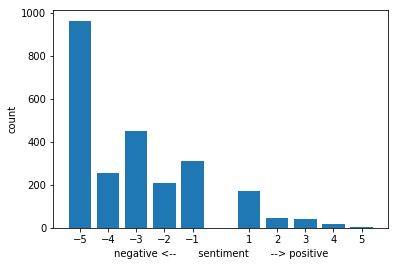

In [43]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [44]:
# How should we score a document?


def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [45]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both too good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [46]:


# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [47]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [48]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets',
                         {'q': 'mcdonalds', 'count': 100}):
    if r['user']['screen_name'] != 'mcdonalds': # exclude tweets from @mcdonalds
        tweets.append(r)

In [49]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [50]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[6]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
RT @salmanbutt_03: jordyn woods, sofia richie, and blac chyna at their local mcdonalds right now
https://t.co/BEoVPCaoYw
to
['rt', 'salmanbutt_03', 'jordyn', 'woods', 'sofia', 'richie', 'and', 'blac', 'chyna', 'at', 'their', 'local', 'mcdonalds', 'right', 'now', 'https', 't', 'co', 'beovpcaoyw']


In [51]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [52]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [53]:
len(negatives)

8

In [54]:
len(positives)

10

In [55]:
# Print top positives:
for tweet, pos, neg in sorted(positives,
                              key=lambda x: x[1],
                              reverse=True):
    print(pos, neg, tweet)

4 0 @Mi_veloso YES! We’re so excited for you, Mirella! Get your minty on!
4 1 Wow, forget about Tim Hortons, McDonalds is giving away the real stuff! #Sens #MelnykOut https://t.co/NUzrfWN1ev
3 0 As part of the BIG Ashfield Spring Clean the McDonalds McOpCo team carried out a litter pick yesterday at their Kin… https://t.co/lDRct71HXs
2 0 RT @nicoletteannmc: Valentines day isn't over yet at Mcdonalds Sta. Clara!!😍 congratulations to the newly engaged couple!😍 #Mayforeversamcd…
2 0 @McDonalds I looked down the scorching hot hole on top of cup but didnt see anything. @joerogan https://t.co/b2RxuIlNaa
2 0 RT @nicoletteannmc: Valentines day isn't over yet at Mcdonalds Sta. Clara!!😍 congratulations to the newly engaged couple!😍 #Mayforeversamcd…
1 0 McDonald’s expands global headquarters’ menu with new items https://t.co/ziWucWfn2p
1 0 I want @BurgerKing fries right now more than everything and definitely more than @McDonalds
1 0 @GegenDepress @mboreham1 @Evertxn @fvr77 A UBI does not motiva

In [57]:
afinn_sentiment2(tokenize('I want @BurgerKing fries right now more than everything and definitely more than @McDonalds'),
                 afinn, verbose=True)

	want=1


(1, 0)

In [58]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 6 No no no no no no MCDONALDS!!!!!!!!
0 4 my cheap ass will always think mcdonalds when my friends say they wanna go eat somewhere
0 3 omg david was deadass wearing those ugly mcdonalds pants in james’ video im- what have you done @carlyincontro https://t.co/0WHCOE8czj
0 2 Also, I am a regular at McDonalds and for my sister to be treated as such is unacceptable. Thankfully, the one in p… https://t.co/ZHJHsLLCR8
0 2 @tailopez ray kroc started the mcdonalds CORPORATION if im not mistaken, it was founded by the mcdonalds brothers but yea, just a nitpick
0 1 Oye ya po. Hasta cuando no disponible McDonald's en Uber Eats?! 

QUIERO MI CUARTO DE LIBRA AHOOORAAAA!!!!!! @McDonalds_Cl @UberEats_Chile
0 1 RT @VVickypalawan: Why are you at mcdonalds at 10am veronica? You no life ah. https://t.co/zAoHqUm6Dq
0 1 RT @VVickypalawan: Why are you at mcdonalds at 10am veronica? You no life ah. https://t.co/zAoHqUm6Dq


In [59]:
afinn_sentiment2(tokenize("Also, I am a regular at McDonalds and for my sister to be treated as such is unacceptable. Thankfully, the one in p"),
                 afinn, verbose=True)

	unacceptable=-2


(0, 2)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [60]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(),
                       key=lambda x:x[1],
                       reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%20s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

                  no count=9 sentiment=-1
     congratulations count=2 sentiment=2
                 yes count=2 sentiment=1
                 top count=1 sentiment=2
             expands count=1 sentiment=1
                ugly count=1 sentiment=-3
             excited count=1 sentiment=3
                 wow count=1 sentiment=4
              forget count=1 sentiment=-1
                want count=1 sentiment=1
            motivate count=1 sentiment=1


In [61]:
[t for t in tokens if 'yes' in t]

[['mi_veloso',
  'yes',
  'we',
  're',
  'so',
  'excited',
  'for',
  'you',
  'mirella',
  'get',
  'your',
  'minty',
  'on'],
 ['tailopez',
  'yes',
  'ray',
  'kroc',
  'didn',
  't',
  'start',
  'mcdonalds',
  'though']]

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [62]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
# must run nltk.download('sentiwordnet')
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

happy(a): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [63]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [64]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [65]:
good = list(swn.senti_synsets('good', 'a'))[0]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (good.neg_score(), good.pos_score(), good.obj_score()))

good(a): negative_score=0.00 positive_score=0.75 objective_score=0.25


In [66]:
good = list(swn.senti_synsets('good', 'a'))
good

[SentiSynset('good.a.01'),
 SentiSynset('full.s.06'),
 SentiSynset('good.a.03'),
 SentiSynset('estimable.s.02'),
 SentiSynset('beneficial.s.01'),
 SentiSynset('good.s.06'),
 SentiSynset('good.s.07'),
 SentiSynset('adept.s.01'),
 SentiSynset('good.s.09'),
 SentiSynset('dear.s.02'),
 SentiSynset('dependable.s.04'),
 SentiSynset('good.s.12'),
 SentiSynset('good.s.13'),
 SentiSynset('effective.s.04'),
 SentiSynset('good.s.15'),
 SentiSynset('good.s.16'),
 SentiSynset('good.s.17'),
 SentiSynset('good.s.18'),
 SentiSynset('good.s.19'),
 SentiSynset('good.s.20'),
 SentiSynset('good.s.21')]

**We can't set these numbers all by hand.**

**How can we come up with these numbers in a principled way??**

$\rightarrow$ Machine Learning